In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
warnings.filterwarnings(action='ignore')

# Table of Contents
* [Section 1. Data preparation](#sec1)
    * [Section 1.1 Read data and understand data patterns](#sec1_1)
    * [Section 1.2 Check data anomalies and data cleaning](#sec1_2)
* [Section 2. Sales Forecast](#sec2)
    * [Section 2.1 Sales data explore](#sec2_1)
    * [Section 2.2 Sales forecast (GradientBoostRegression)](#sec2_2)
    * [Section 2.3 Sales forecast (SARIMA)](#sec2_3)
* [Section 3. Customer Segmentation](#sec3)
    * [Section 3.1 RFM feature extraction](#sec3_1)
    * [Section 3.2 Other feature extraction](#sec3_2)
    * [Section 3.3 Correlation Analysis](#sec3_3)
    * [Section 3.4 Outlier Removal](#sec3_4)
    * [Section 3.5 Feature Normalization](#sec3_5)
    * [Section 3.6 Dimensionality Reduction](#sec3_6)
    * [Section 3.7 Clustering](#sec3_7)
    * [Section 3.8 Feature Importance Analysis](#sec3_8)

# Section 1. Data preparation <a class="anchor" id="sec1"></a>

# Section 1.1 Read data and understand data patterns <a id="sec1_1"></a>

In [3]:
df = pd.read_csv('data.csv', encoding="ISO-8859-1")

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
#df.describe(include='object').T # categorical
#df.describe().T # numerical
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
InvoiceNo,541909,25900,573585,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,541909,4070,85123A,2313,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,541909.0,NaN,NaN,NaN,9.55225,218.081158,-80995.0,1.0,3.0,10.0,80995.0
InvoiceDate,541909,23260,10/31/2011 14:41,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,541909.0,NaN,NaN,NaN,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,NaN,NaN,NaN,15287.69057,1713.600303,12346.0,13953.0,15152.0,16791.0,18287.0
Country,541909,38,United Kingdom,495478,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
null_count = df.isnull().sum()
null_percentage = null_count / (df.shape[0]+0.0001) * 100
print('count and percentages of null values for each column:\n', pd.concat([null_count, null_percentage], axis=1))

count and percentages of null values for each column:
                   0          1
InvoiceNo         0   0.000000
StockCode         0   0.000000
Description    1454   0.268311
Quantity          0   0.000000
InvoiceDate       0   0.000000
UnitPrice         0   0.000000
CustomerID   135080  24.926694
Country           0   0.000000


### plot missing data examples

In [8]:
df[df["Description"].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom


In [9]:
df[df["CustomerID"].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


# Section 1.2 Check data pattern/anomalies and data cleaning <a id="sec1_2"></a>

## 1) InvoiceNo
- not always numercial values. can be e.g.,C536379
- always between 6-7 chars

In [10]:
# not always numerical values
# is_numeric = df['InvoiceNo'].str.isdigit().all() -> false

# examples when they are not digit
is_numeric = df['InvoiceNo'].str.isdigit()
df[~df["InvoiceNo"].str.isdigit()]

# InvoiceNo string length always between 6 ~ 7
InvoiceNo_length = [df['InvoiceNo'].str.len().min(),df['InvoiceNo'].str.len().max()]

## 1) StockCode
- product id
- not always digital values, e.g., 85123A
- string length between 1 ~ 12. 89% of them contains 5 chars
- filter out stockcode whose length <= 4 chars. We assume those products are not really products, but rather e.g., shipment cost

In [11]:
# not always numerical values
is_numeric = df['StockCode'].str.isdigit().all() #-> false

# examples when they are not digit
is_numeric = df['StockCode'].str.isdigit()
df[~df["StockCode"].str.isdigit()]

# InvoiceNo string length between 1 ~ 12
StockCode_length = [df['StockCode'].str.len().min(),df['StockCode'].str.len().max()]

# check frequencies of StockCode with str length 1 ~ 12
result = df.groupby(df['StockCode'].str.len())['StockCode'].count()#['StockCode'].str.len().count_values()

result / df.shape[0] * 100

# check how each StockCode looks like with str length 1 ~ 12
df[df["StockCode"].str.len() == 4]["StockCode"]# D, M,C2, DOT, POST...doest represent product

# filter out stock code whose length <= 4
df = df[df["StockCode"].str.len() > 4]

## 3) Description (omit this column as it will not be used for data analysis)
This column serves as reference information for the analyst

## 4) Quantity
- int64 numerical type
- check histogram. there exists a small amount of negative values, representing returned products
- Return order starts with "C" in InvoiceNo
- there are 2 big purchase and returns (>|20000|). returns and purchase are the same products. These four recordings should be filtered out, because the returns happened right after purchase, indicating that they are accidental orders
- add "Return" = {"Yes", "No"} column to identify if a transaction is buy or return

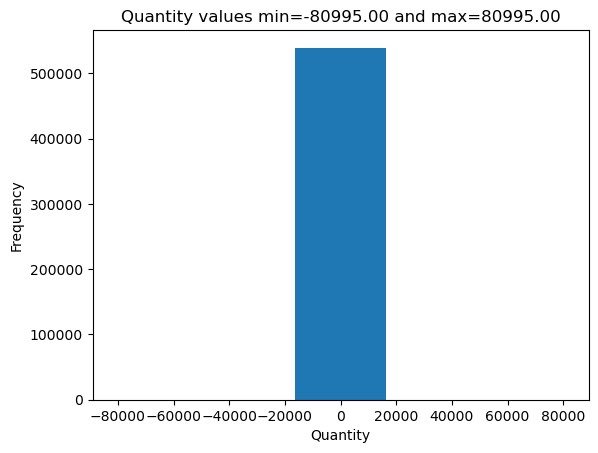

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346.0,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.08,16446.0,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,12/9/2011 9:27,2.08,16446.0,United Kingdom


In [12]:
plt.hist(df['Quantity'],bins=5)
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.title('Quantity values min={:.2f} and max={:.2f}'.format(df['Quantity'].min(),df['Quantity'].max()))
#plt.ylim(0, 5000)
plt.show()

# check
df[(df['Quantity']<-20000) | (df['Quantity']>20000)]

In [13]:
df = df[df['Quantity'].abs() < 20000]
df[(df['Quantity']<20000) | (df['Quantity']>-20000)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


### add a column "Return" ("Yes" or "No"): if a transaction is buy or return

In [14]:
df['Return'] = df['Quantity'].apply(lambda x: 'Yes' if x < 0 else 'No')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Return
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,No
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,No
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,No
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,No
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,No
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,No
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,No
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,No
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,No


## 5) InvoiceDate
- contains only date values
- compute new time measures for the convenience of analysis later

In [15]:
# check if they are all dates 
try:
    pd.to_datetime(df['InvoiceDate'])
    print(f"The column InvoiceDate contains only valid date values.")
except ValueError:
    print(f"The column InvoiceDate does not contain only valid date values.")

The column InvoiceDate contains only valid date values.


In [16]:
# convert to date type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# compute useful time measures
df["InvoiceYear"] = df['InvoiceDate'].dt.year
df["InvoiceMonth"] = df['InvoiceDate'].dt.month
df["InvoiceDay"] = df['InvoiceDate'].dt.date
df["InvoiceDayofWeek"] = df['InvoiceDate'].dt.dayofweek + 1 # Monday is the first day
df["InvoiceDayName"] = df["InvoiceDate"].dt.day_name()
df['Hour'] = df['InvoiceDate'].dt.strftime('%H')
df['InvoiceDaytoLatest'] = (df['InvoiceDay'].max() - df['InvoiceDay']).dt.days
df['InvoiceDaytoEarliest'] = (df['InvoiceDay']-df['InvoiceDay'].min()).dt.days + 1

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Return,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceDayofWeek,InvoiceDayName,Hour,InvoiceDaytoLatest,InvoiceDaytoEarliest
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,No,2010,12,2010-12-01,3,Wednesday,08,373,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,No,2010,12,2010-12-01,3,Wednesday,08,373,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,No,2010,12,2010-12-01,3,Wednesday,08,373,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,No,2010,12,2010-12-01,3,Wednesday,08,373,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,No,2010,12,2010-12-01,3,Wednesday,08,373,1


## 6) UnitPrice
- 2500 purchase with UnitPrice = 0, small proportion of total data. So delete them

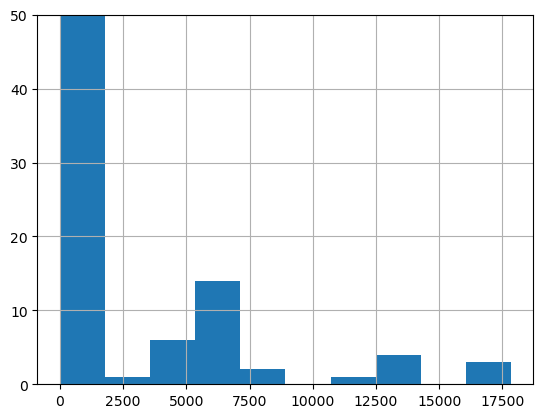

In [17]:
df["UnitPrice"].hist() 
plt.ylim(0, 50)
plt.show()

(df["UnitPrice"]==0).sum() # = 2500

df = df[df["UnitPrice"]>0]

## 7) Customer ID
- data type is float
- 25% customerID is missing. These may be unregistered customers and are valuable information

In [18]:
customerid_null_percentage = df['CustomerID'].isnull().sum() / df['CustomerID'].shape[0]

# show examples when CustomerID is null
df_CustomerID_isnull = df[df['CustomerID'].isnull()]
df_CustomerID_isnull.head(20)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Return,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceDayofWeek,InvoiceDayName,Hour,InvoiceDaytoLatest,InvoiceDaytoEarliest
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom,No,2010,12,2010-12-01,3,Wednesday,14,373,1
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom,No,2010,12,2010-12-01,3,Wednesday,14,373,1
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom,No,2010,12,2010-12-01,3,Wednesday,14,373,1
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom,No,2010,12,2010-12-01,3,Wednesday,14,373,1
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom,No,2010,12,2010-12-01,3,Wednesday,14,373,1
1448,536544,21791,VINTAGE HEADS AND TAILS CARD GAME,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom,No,2010,12,2010-12-01,3,Wednesday,14,373,1
1449,536544,21801,CHRISTMAS TREE DECORATION WITH BELL,10,2010-12-01 14:32:00,0.43,NaN,United Kingdom,No,2010,12,2010-12-01,3,Wednesday,14,373,1
1450,536544,21802,CHRISTMAS TREE HEART DECORATION,9,2010-12-01 14:32:00,0.43,NaN,United Kingdom,No,2010,12,2010-12-01,3,Wednesday,14,373,1
1451,536544,21803,CHRISTMAS TREE STAR DECORATION,11,2010-12-01 14:32:00,0.43,NaN,United Kingdom,No,2010,12,2010-12-01,3,Wednesday,14,373,1
1452,536544,21809,CHRISTMAS HANGING TREE WITH BELL,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom,No,2010,12,2010-12-01,3,Wednesday,14,373,1


## 8) Country
- study quantity, transactionvalue (quantity*unitprice) by country.
- UK is largest target country

In [19]:
# count Quantity by country
df.groupby('Country')["Quantity"].sum().sort_values(ascending=False)

Country
United Kingdom          4396246
Netherlands              199934
EIRE                     142262
Germany                  116341
France                   109690
Australia                 83345
Sweden                    35599
Switzerland               30227
Spain                     26607
Japan                     25221
Belgium                   22880
Norway                    19188
Portugal                  16082
Finland                   10575
Channel Islands            9476
Denmark                    8147
Italy                      7957
Cyprus                     6316
Singapore                  5234
Austria                    4790
Hong Kong                  4767
Israel                     4353
Poland                     3644
Unspecified                3300
Canada                     2762
Iceland                    2458
Greece                     1550
USA                        1034
United Arab Emirates        981
Malta                       934
Lithuania                   652


#### count Quantity * Unitprice by country, add this new column "TransactionValue" to df

In [20]:
df['TransactionValue'] = df['Quantity'] * df['UnitPrice']

In [21]:
# count TransactionValue by country
df.groupby('Country')["TransactionValue"].sum().sort_values(ascending=False)

Country
United Kingdom          8073707.951
Netherlands              283479.540
EIRE                     259663.460
Germany                  200808.400
France                   182163.390
Australia                136990.000
Switzerland               52505.350
Spain                     51765.200
Belgium                   36662.960
Japan                     35419.790
Sweden                    35176.910
Norway                    32292.960
Portugal                  26871.520
Channel Islands           19936.290
Finland                   18303.540
Denmark                   18042.140
Italy                     15276.340
Cyprus                    12931.290
Hong Kong                  9942.040
Singapore                  9120.390
Austria                    8698.320
Israel                     7907.820
Poland                     6853.140
Unspecified                4749.790
Greece                     4425.520
Iceland                    4310.000
Canada                     3115.440
Malta               

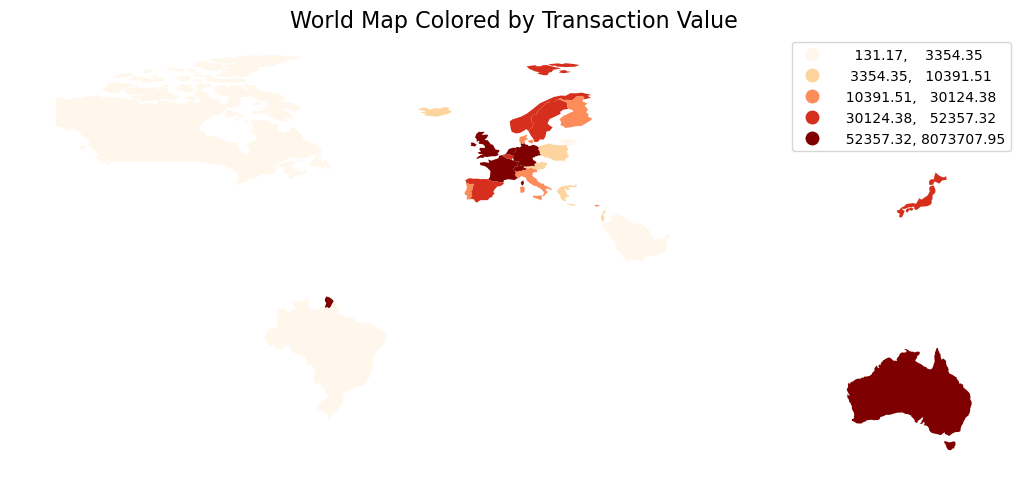

In [22]:
TransactionValue_by_Country = df.groupby('Country')["TransactionValue"].sum().reset_index()
#TransactionValue_by_Country = df.groupby('Country')["TransactionValue"].agg(lambda x: np.log(x.sum())).reset_index()

# Merge country_totals with the world GeoDataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(TransactionValue_by_Country, how='left', left_on='name', right_on='Country')

fig, ax = plt.subplots(1, 1, figsize=(13, 9))
world.plot(column='TransactionValue', 
           cmap='OrRd', 
           scheme = 'quantiles',
           legend=True, 
           ax=ax)

plt.title('World Map Colored by Transaction Value', fontsize = 16)
plt.axis('off')
plt.show()

# Section 2. Sales Forecast <a id="sec2"></a>

## Section 2.1 Sales data explore <a id="sec2_1"></a>
- daily sales slowly increase over time
- TransactionValues(=OrderQuantity*UnitPrice) and Order Quantites reach the maximum value on November, right before holiday seasons.
- ReturnRate ranges between 1% and 5%. Largest return rate happens in April
- As this dataset contains only 1 year recordings, it's hard to conclude a generalized monthly pattern

In [23]:
# quick check the current df
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536560 entries, 0 to 541908
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   InvoiceNo             536560 non-null  object        
 1   StockCode             536560 non-null  object        
 2   Description           536560 non-null  object        
 3   Quantity              536560 non-null  int64         
 4   InvoiceDate           536560 non-null  datetime64[ns]
 5   UnitPrice             536560 non-null  float64       
 6   CustomerID            404884 non-null  float64       
 7   Country               536560 non-null  object        
 8   Return                536560 non-null  object        
 9   InvoiceYear           536560 non-null  int64         
 10  InvoiceMonth          536560 non-null  int64         
 11  InvoiceDay            536560 non-null  object        
 12  InvoiceDayofWeek      536560 non-null  int64         
 13 

Text(0.5, 1.0, 'Daily TransactionValue and OrderQuantity over time. The correlation coefficient is 0.91')

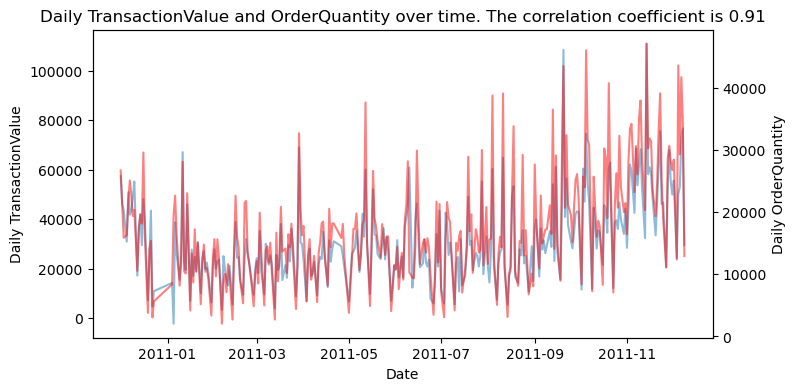

In [24]:
# transactionvalue and quantity over date
TotalSalesQuantity = df.groupby('InvoiceDay').agg({'TransactionValue': ['sum'], 'Quantity':['sum']}).reset_index()
coef = np.corrcoef(TotalSalesQuantity['TransactionValue'].to_numpy().flatten(),TotalSalesQuantity['Quantity'].to_numpy().flatten())[0,1]

TotalSalesQuantity

fig, ax1 = plt.subplots(1,1, figsize=(8, 4))

ax1.plot(TotalSalesQuantity['InvoiceDay'], TotalSalesQuantity['TransactionValue'],alpha=0.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily TransactionValue')

ax2 = ax1.twinx()
ax2.plot(TotalSalesQuantity['InvoiceDay'], TotalSalesQuantity['Quantity'],'r',alpha=0.5)
ax2.set_ylabel('Daily OrderQuantity')
plt.title('Daily TransactionValue and OrderQuantity over time. The correlation coefficient is {:.2f}'.format(coef))

,InvoiceDay,ReturnQuantity,TotalQuantity,ReturnRate
0,2010-12-01,182.0,26909,0.676354
1,2010-12-02,10287.0,31328,32.836440
2,2010-12-03,291.0,16177,1.798850
3,2010-12-05,55.0,16371,0.335960
4,2010-12-06,298.0,21768,1.368982
...,...,...,...,...
300,2011-12-05,124.0,43755,0.283396
301,2011-12-06,1106.0,30437,3.633735
302,2011-12-07,106.0,41858,0.253237
303,2011-12-08,639.0,35066,1.822278


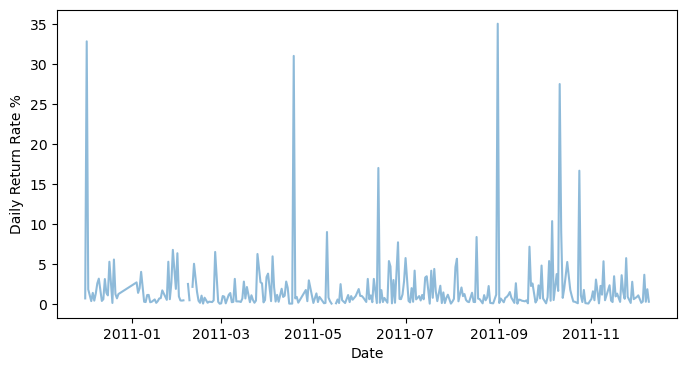

In [25]:
# return rate over date
ReturnQuantity = df[df['Return']=='Yes'].groupby('InvoiceDay')['Quantity'].agg(ReturnQuantity = lambda x: np.abs(x).sum())#{'Quantity'}: ['sum'])# 
TotalQuantity = df[df['Return']=='No'].groupby('InvoiceDay')['Quantity'].agg(TotalQuantity = lambda x: np.abs(x).sum()) # .size() return the number of records

df_Return = pd.DataFrame({'InvoiceDay': df['InvoiceDay'].unique()})
df_Return = df_Return.merge(ReturnQuantity, on='InvoiceDay', how='left')
df_Return = df_Return.merge(TotalQuantity, on='InvoiceDay', how='left')
df_Return['ReturnRate'] = df_Return['ReturnQuantity'] / df_Return['TotalQuantity'] * 100


# plot return rate

fig, ax1 = plt.subplots(1,1, figsize=(8, 4))

ax1.plot(df_Return['InvoiceDay'], df_Return['ReturnRate'],alpha=0.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Return Rate %')

df_Return

Text(0.5, 1.0, 'Monthly TransactionValue and OrderQuantity. The correlation coefficient is 0.99')

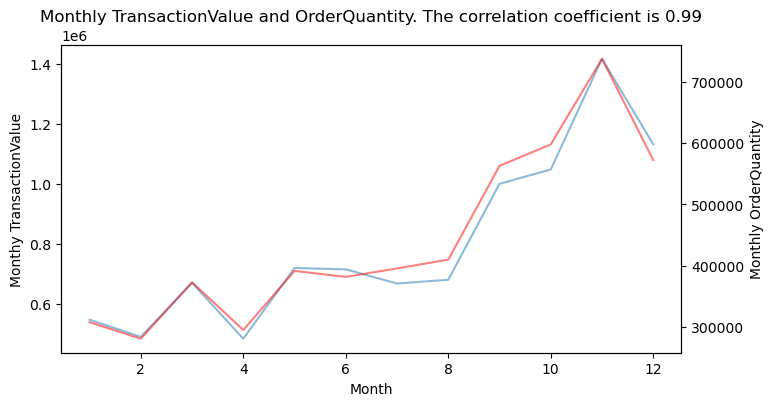

In [26]:
# transactionvalue and quantity over Month
TotalSalesQuantity = df.groupby('InvoiceMonth').agg({'TransactionValue': ['sum'], 'Quantity':['sum']}).reset_index()
coef = np.corrcoef(TotalSalesQuantity['TransactionValue'].to_numpy().flatten(),TotalSalesQuantity['Quantity'].to_numpy().flatten())[0,1]


fig, ax1 = plt.subplots(1,1, figsize=(8, 4))

ax1.plot(TotalSalesQuantity['InvoiceMonth'], TotalSalesQuantity['TransactionValue'],alpha=0.5)
ax1.set_xlabel('Month')
ax1.set_ylabel('Monthy TransactionValue')

ax2 = ax1.twinx()
ax2.plot(TotalSalesQuantity['InvoiceMonth'], TotalSalesQuantity['Quantity'],'r',alpha=0.5)
ax2.set_ylabel('Monthly OrderQuantity')
plt.title('Monthly TransactionValue and OrderQuantity. The correlation coefficient is {:.2f}'.format(coef))

Text(0, 0.5, 'Monthly Return Rate %')

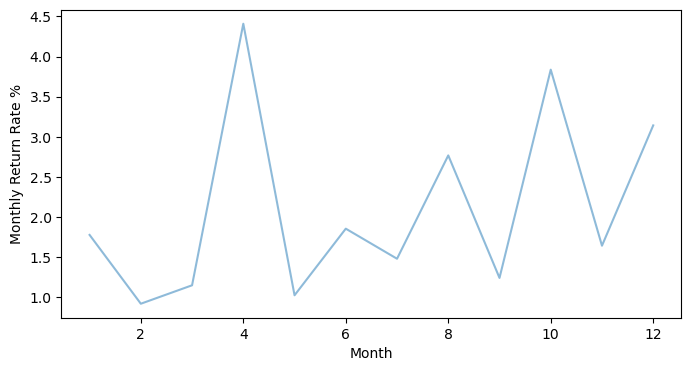

In [27]:
# return rate over month
ReturnQuantity = df[df['Return']=='Yes'].groupby('InvoiceMonth')['Quantity'].agg(ReturnQuantity = lambda x: np.abs(x).sum())#{'Quantity'}: ['sum'])# 
TotalQuantity = df[df['Return']=='No'].groupby('InvoiceMonth')['Quantity'].agg(TotalQuantity = lambda x: np.abs(x).sum()) # .size() return the number of records

df_Return = pd.DataFrame({'InvoiceMonth': df['InvoiceMonth'].unique()})
df_Return = df_Return.merge(ReturnQuantity, on='InvoiceMonth', how='left')
df_Return = df_Return.merge(TotalQuantity, on='InvoiceMonth', how='left')
df_Return['ReturnRate'] = df_Return['ReturnQuantity'] / df_Return['TotalQuantity'] * 100
df_Return = df_Return.sort_values(by='InvoiceMonth')
df_Return

# plot return rate
fig, ax1 = plt.subplots(1,1, figsize=(8, 4))
ax1.plot(df_Return['InvoiceMonth'], df_Return['ReturnRate'],alpha=0.5)
ax1.set_xlabel('Month')
ax1.set_ylabel('Monthly Return Rate %')

### How many products sold per day?

Text(0.5, 1.0, 'Sales quantity over date')

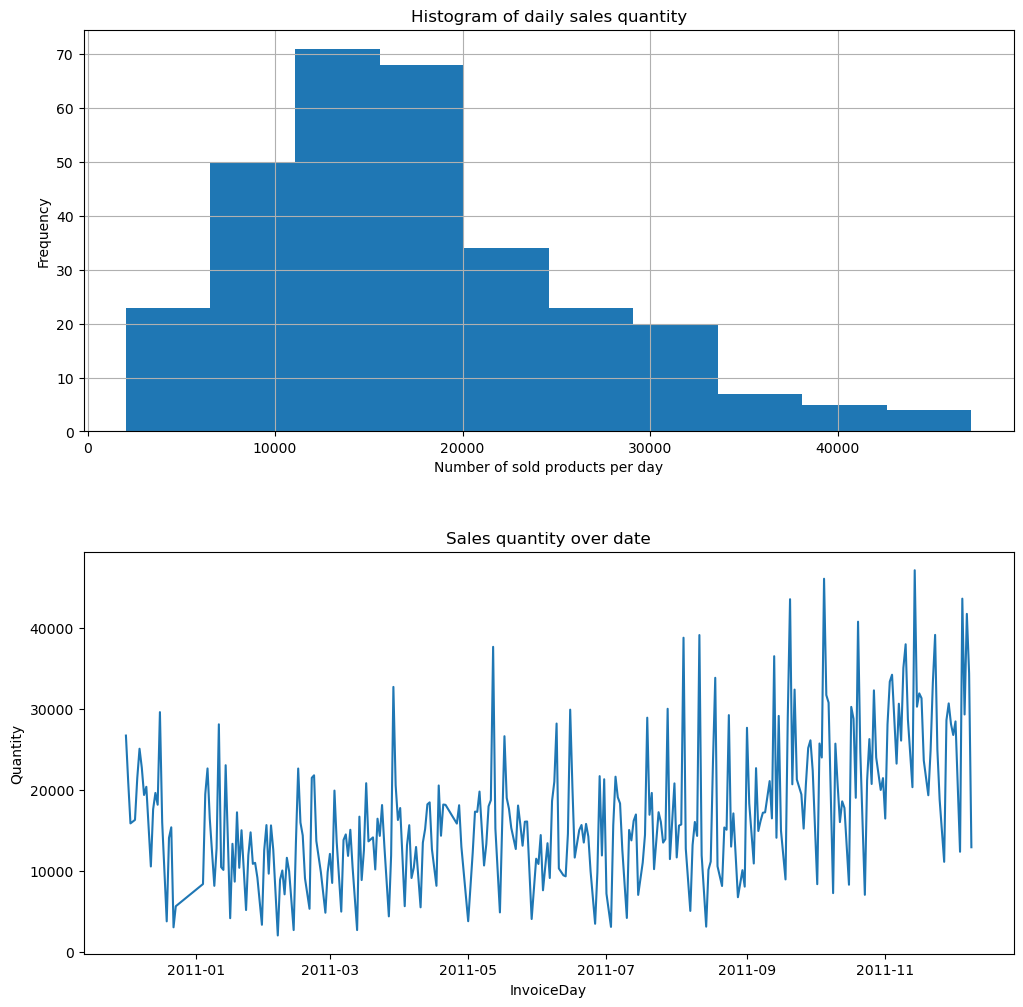

In [28]:
# transactionvalue and quantity over InvoiceDay
TotalSalesQuantity = df.groupby('InvoiceDay').agg({'TransactionValue': ['sum'], 'Quantity':['sum']}).reset_index()


fig, ax = plt.subplots(2, 1, figsize=(12, 12))

TotalSalesQuantity['Quantity'].hist(ax=ax[0])
ax[0].set_xlabel('Number of sold products per day')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Histogram of daily sales quantity')

ax[1].plot(TotalSalesQuantity['InvoiceDay'], TotalSalesQuantity['Quantity'])
ax[1].set_xlabel('InvoiceDay')
ax[1].set_ylabel('Quantity')
ax[1].set_title('Sales quantity over date')

### What are the top 10 products (according to Purchase Quantity)?

In [29]:
PopularProduct = df.groupby(['StockCode']).agg({'TransactionValue': ['sum'], 'Quantity':['sum']}).reset_index()

sorted_df = PopularProduct.sort_values(by=('Quantity', 'sum'),ascending=False)
sorted_df.head(10)

,StockCode,TransactionValue,Quantity
,,sum,sum
1112,22197,50987.47,56450
2915,84077,13587.93,53847
3400,85099B,92356.03,47359
3201,84879,58959.73,36381
440,21212,21059.72,36039
3420,85123A,97894.50,35082
1945,23084,66756.59,30680
1377,22492,16810.42,26437
1495,22616,7972.76,26111


### How many times a product was sold?

In [30]:
df.groupby('StockCode')["Quantity"].count().sort_values(ascending=False)

StockCode
85123A    2307
22423     2198
85099B    2156
47566     1726
20725     1639
          ... 
84743C       1
90167        1
20678        1
90048        1
20957        1
Name: Quantity, Length: 3927, dtype: int64

### analyze the most sold product 22197

array([[ 1.        , -0.07774803],
       [-0.07774803,  1.        ]])

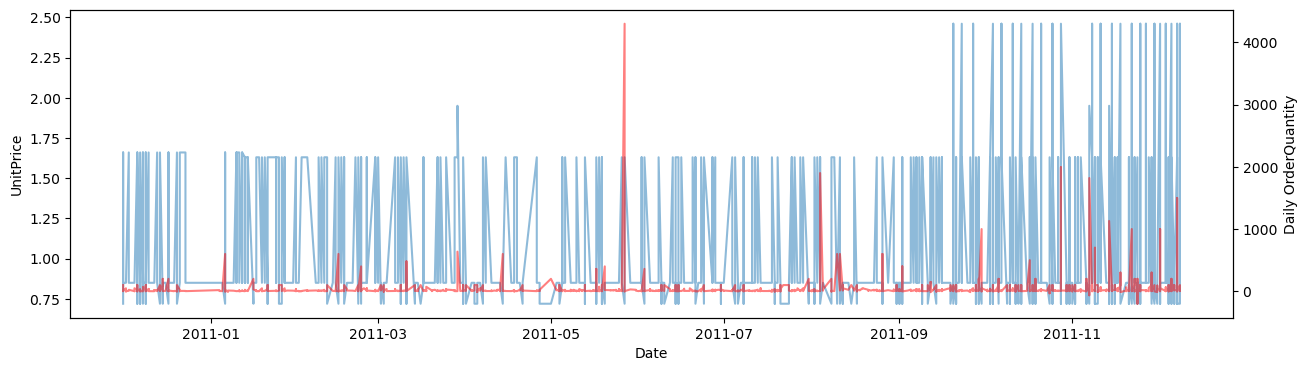

In [31]:
df_Product_22197 = df[df['StockCode']=='22197']

fig, ax1 = plt.subplots(1,1, figsize=(15, 4))

ax1.plot(df_Product_22197['InvoiceDay'],df_Product_22197['UnitPrice'], alpha=0.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('UnitPrice')

# compute Quantity
ax2 = ax1.twinx()
ax2.plot(df_Product_22197['InvoiceDay'], df_Product_22197['Quantity'],'r',alpha=0.5)
ax2.set_ylabel('Daily OrderQuantity')

np.corrcoef(df_Product_22197['UnitPrice'],df_Product_22197['Quantity'])

## Section 2.2 Sales forecast (GradientBoostRegression) <a id="sec2_2"></a>

### Feature engineering for sales forecast (Sales Quantity over InvoiceDay)

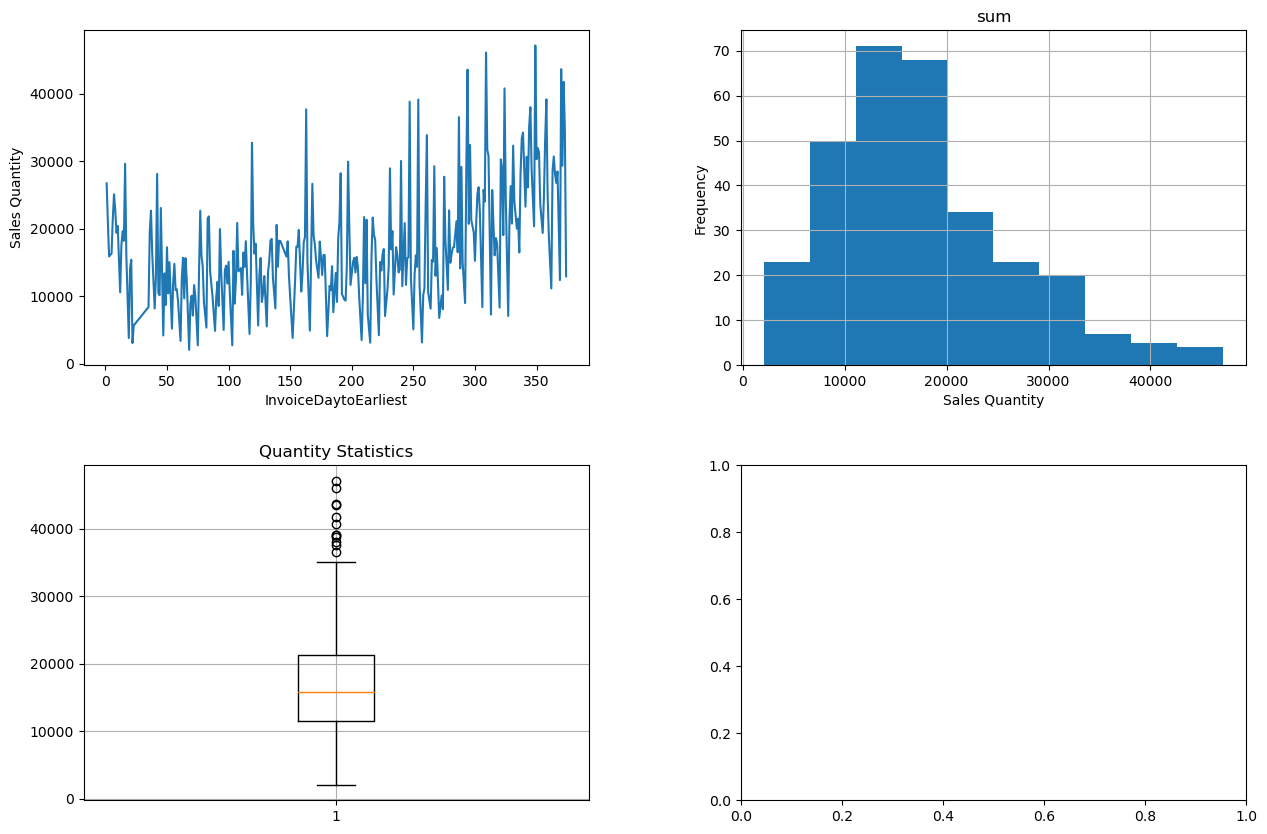

In [32]:
sales_feature = df.groupby(['InvoiceDaytoEarliest','InvoiceMonth','InvoiceDayofWeek']).agg({'TransactionValue': ['sum'], 'Quantity':['sum']}).reset_index()
sales_feature.head()

fig, ax = plt.subplots(2,2,figsize=(15,10))
ax[0,0].plot(sales_feature['InvoiceDaytoEarliest'],sales_feature['Quantity'])
ax[0,0].set_xlabel('InvoiceDaytoEarliest')
ax[0,0].set_ylabel('Sales Quantity')

sales_feature['Quantity'].hist(ax=ax[0,1])
ax[0,1].set_xlabel('Sales Quantity')
ax[0,1].set_ylabel('Frequency')

ax[1,0].boxplot(sales_feature['Quantity'])
ax[1,0].set_title('Quantity Statistics')
ax[1,0].grid(True)

### remove outliers as they can impact training process
The time series of SalesQuantity contains outliers, which can impact the ML train/validation process (MSE will be large when including outlier samples). Thus, we filter out data beyond lower and higher bounds defined by k (%) and (100-k) (%)

In [33]:
# compute lowbound and highbound
k = 0.01
quantity_lowbound = sales_feature.Quantity.quantile(k*2)
quantity_highbound = sales_feature.Quantity.quantile(1-k)

# compute a mask to exclude outlier data points
inlier_mask = (sales_feature['Quantity'] < quantity_highbound) & (sales_feature['Quantity'] > quantity_lowbound)
inlier_mask = inlier_mask.values.reshape(-1,)
percentage_kept = float(np.sum(inlier_mask)/inlier_mask.shape[0] * 100)

print('{:.2f}% data kept after outlier filter'.format(percentage_kept))

96.39% data kept after outlier filter


### Train/Validation/Test Split and rescale Quantity using log()

Text(0.5, 0, 'InvoiceDaytoEarliest')

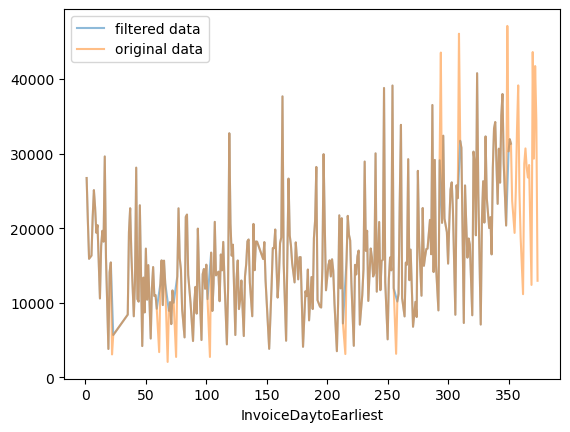

In [34]:
from sklearn.model_selection import TimeSeriesSplit

# split train/validation and test samples
# split features and label
X = sales_feature.drop(['Quantity','TransactionValue'], axis="columns")
y = sales_feature['Quantity']

# convert X and y to numpy
X = X.to_numpy()
y = y.to_numpy()

# separate train/validation and test set
percentage_trainval = 0.94
num_trainval_samples = int(X[inlier_mask,:].shape[0] * percentage_trainval)

X_trainval = X[inlier_mask][:num_trainval_samples,:]
y_trainval = np.log(y[inlier_mask][:num_trainval_samples,:])

X_test = X[inlier_mask][num_trainval_samples:,:]
y_test = np.log(y[inlier_mask][num_trainval_samples:,:])


# split train and validation samples 
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=0,
    max_train_size=None,
    test_size=None,
)

# splitting result
all_splits = list(ts_cv.split(X, y))

# check filtered y_trainval
#print(str(y_trainval.shape) + " " + str(y[:index_train_samples,:].shape))
plt.plot(X_trainval[:,0],np.exp(y_trainval),alpha=0.5, label='filtered data')
plt.plot(X[:,0],y,alpha=0.5, label='original data')
plt.legend()
plt.xlabel('InvoiceDaytoEarliest')

### Use gradientboosting model


In [35]:
def plot_train_loss(trained_model):
    # plot loss of model training
    # input: trained model
    if hasattr(trained_model, 'train_score_'):
        train_scores = np.asarray(trained_model.train_score_)
        plt.plot(np.arange(train_scores.shape[0]) + 1, train_scores, label='Train Loss')
        plt.xlabel('Number of Iterations')
        plt.ylabel('Training Loss')
        plt.title('Training Loss Change')
        plt.legend()
        plt.show()
    else:
        print("Training loss information not available for the selected model.")

Best Hyperparameters: {'learning_rate': 0.005, 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 500, 'subsample': 0.3}


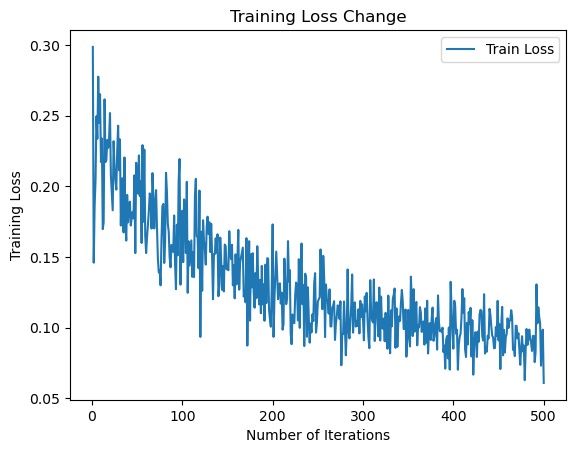

MSE of the best model on validation data: 0.0954523105181775
MSE of best model on test data: 0.08162753171922456


In [36]:
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_squared_log_error

# parameter grid
param_grid = {
    'n_estimators': [1, 100, 200, 500],
    'learning_rate': [0.005, 0.01, 0.05],
    'max_depth': [3],
    'subsample': [0.3, 0.5, 0.7, 1],
    'min_samples_split': [2,3]
}
# model
model = ensemble.GradientBoostingRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=ts_cv, scoring='neg_mean_squared_error')##neg_mean_squared_error

# Perform Grid Search with Cross-Validation
grid_search.fit(X_trainval, y_trainval)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# get train loss
plot_train_loss(best_model)
    
# predict on the validation data and compute mse 
y_pred_val = best_model.predict(X_trainval)
mse = mean_squared_error(y_trainval, y_pred_val)
print("MSE of the best model on validation data:", mse)

# Evaluation on the test data
y_pred_test = best_model.predict(X_test).reshape(-1,1)
mse = mean_squared_error(y_test, y_pred_test)
print("MSE of best model on test data:", mse)


### Finally, we plot the Sales Quantity on the whole dataset, inluding train/validation and test data.
Test data starts after the red dashline.

Text(0, 0.5, 'Sales Quantity')

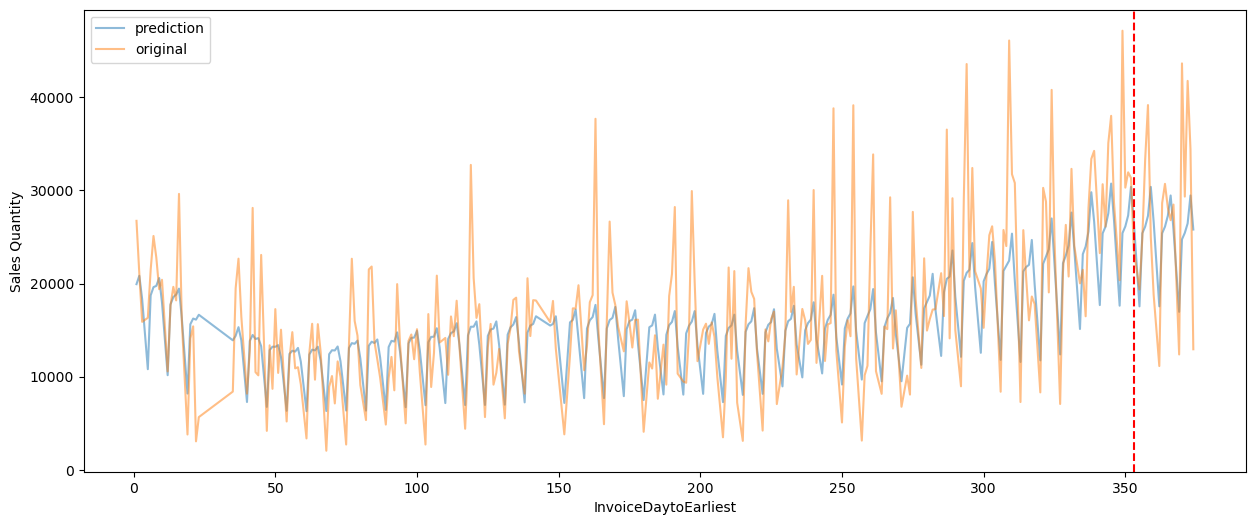

In [37]:
# prediction on the whole dataset
y_pred = best_model.predict(X).reshape(-1,1)
y_pred = np.exp(y_pred)

fig, ax = plt.subplots(1,1,figsize = (15,6))
plt.plot(X[:,0], y_pred, alpha=0.5, label='prediction')
plt.plot(X[:,0], y, alpha=0.5, label = 'original')
plt.axvline(x=X_test[0,0], color='r', linestyle='--')
plt.legend()
plt.xlabel('InvoiceDaytoEarliest')
plt.ylabel('Sales Quantity')

## Section 2.3 Sales forecast (SARIMA) <a id="sec2_3"></a>

### 1) Is the data continuous?
- Data is not contiuous. Most sampling interval is between 1 and 2. Largest sampling intervals can reach 12 (days).
- Fill in missing data with NaN

Text(0, 0.5, 'diff(next-previous)')

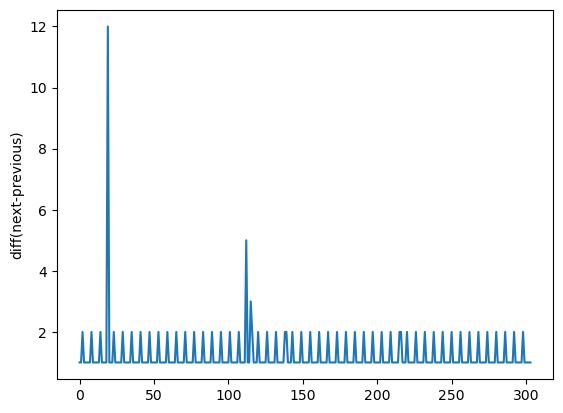

In [38]:
InvoiceDaytoEarliest = sales_feature['InvoiceDaytoEarliest'].values
plt.plot(np.diff(InvoiceDaytoEarliest))
plt.ylabel('diff(next-previous)')

In [39]:
# fill in with nan
InvoiceDaytoEarliest_impute = np.arange(1,np.max(InvoiceDaytoEarliest))
Quantity_impute = np.full_like(InvoiceDaytoEarliest_impute, np.nan, dtype=float)

for x, y in zip(InvoiceDaytoEarliest, sales_feature['Quantity'].values):
    index = np.where(InvoiceDaytoEarliest_impute == x)[0]
    if len(index) > 0:
        Quantity_impute[index[0]] = y
        
Quantity_impute

array([26727., 21041., 15886.,    nan, 16316., 21470., 25102., 22769.,
       19389., 20401.,    nan, 10565., 17617., 19643., 18190., 29620.,
       16004.,    nan,  3790., 14096., 15398.,  3055.,  5657.,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,  8395., 19489., 22667., 16446.,    nan,  8175.,
       12825., 28116., 10486., 10140., 23067.,    nan,  4179., 13364.,
        8692., 17252., 10402., 15039.,    nan,  5188., 11949., 14778.,
       10892., 11013.,  9178.,    nan,  3367., 12542., 15676.,  9677.,
       15636., 12634.,    nan,  2048.,  8914., 10067.,  7125., 11637.,
        9994.,    nan,  2715., 13534., 22659., 15983., 14402.,  9102.,
          nan,  5342., 21510., 21822., 13719., 11843.,  9875.,    nan,
        4857.,  9868., 12118.,  8533., 19934., 13554.,    nan,  4992.,
       13829., 14524., 11871., 15095., 10479.,    nan,  2714., 16716.,
        8889., 12558., 20845., 13664.,    nan, 14156., 10199., 16463.,
      

### 2) Is the data stationary?

In [40]:
from statsmodels.tsa.stattools import adfuller
#  unit root test
# H0 (not stationary)
result = adfuller(sales_feature['Quantity'].values)
p_val = result[1] 
if p_val <= 0.05:
    print('Reject H0. Data is stationary. P-value={:.2f}'.format(p_val))
else:
    print('Accept H0. Data is not stationary. P-value={:.2f}'.format(p_val))


Accept H0. Data is not stationary. P-value=0.82


### 2) This data is not stationary, so we use SARIMA model
We take 80% of the given time series as training samples and the rest are used as test samples. 
The figure below presents the Sales Quantity change over InvoiceDaytoEarliest (Current Day - First Day). The plot in orange shows the samples of the input data, where missing values are filled with NaN; samples on the left side of the red dash line are used as training samples. The plot in blue shows the prediction result of the complete time series using the trained SARIMA model.

Mean MAPE score computed by the testset is: 29.11%


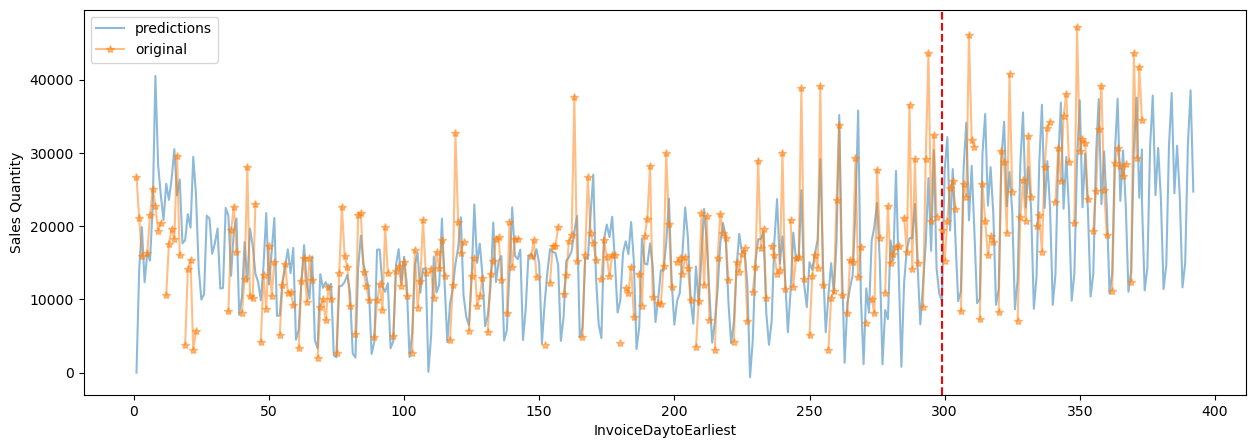

In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# use last 1-k % as test data
k = 0.8
num_trainsamples = int(Quantity_impute.shape[0] * k)
sarima = SARIMAX(Quantity_impute[:num_trainsamples],
                order=(2,1,5),
                seasonal_order=(2,1,0,7))


num_predict_future = 20
predictions = sarima.fit().predict(start=0, end=Quantity_impute.shape[0]+num_predict_future-1)

# compute MAPE score
mape_score = (abs(Quantity_impute[num_trainsamples:]-predictions[num_trainsamples:Quantity_impute.shape[0]])/Quantity_impute[num_trainsamples:])*100
mape_mean = np.nanmean(mape_score)
print('Mean MAPE score computed by the testset is: {:.2f}%'.format(mape_mean))


plt.figure(figsize=(15, 5))
plt.plot(np.concatenate((InvoiceDaytoEarliest_impute,np.arange(np.max(InvoiceDaytoEarliest_impute),np.max(InvoiceDaytoEarliest_impute)+num_predict_future)),axis=0),predictions, alpha=0.5, label='predictions')
plt.plot(InvoiceDaytoEarliest_impute,Quantity_impute, alpha=0.5, label='original',marker='*')
plt.xlabel('InvoiceDaytoEarliest')
plt.ylabel('Sales Quantity')
plt.axvline(x=InvoiceDaytoEarliest_impute[num_trainsamples], color='r', linestyle='--')
plt.legend()

In [42]:
# another option to use auto sarima
'''
from pmdarima import auto_arima

sales_feature = df.groupby(['InvoiceDay','InvoiceDaytoEarliest']).agg({'Quantity':['sum']}).reset_index()
sales_feature.set_index('InvoiceDay',inplace=True)

sales_feature_train = sales_feature.drop(columns=['InvoiceDaytoEarliest'])
model = auto_arima(sales_feature_train, seasonal=True, m=7, trace=True)

# Forecast future values
forecast = model.predict_in_sample()

forecast_future = model.predict(n_periods=70)  # Replace 10


prediction = np.concatenate((forecast,forecast_future),axis=0)


differe = prediction.shape[0]-sales_feature['InvoiceDaytoEarliest'].values.shape[0]

new_x = np.concatenate((sales_feature['InvoiceDaytoEarliest'].values,np.arange(np.max(sales_feature['InvoiceDaytoEarliest'].values),np.max(sales_feature['InvoiceDaytoEarliest'].values)+differe)),axis=0)

plt.figure(figsize=(15, 6))
plt.plot(new_x,prediction,label='prediction',alpha=0.5)
plt.plot(sales_feature['InvoiceDaytoEarliest'].values,sales_feature['Quantity'].values,label='original',alpha=0.5)
plt.legend()
'''

"\nfrom pmdarima import auto_arima\n\nsales_feature = df.groupby(['InvoiceDay','InvoiceDaytoEarliest']).agg({'Quantity':['sum']}).reset_index()\nsales_feature.set_index('InvoiceDay',inplace=True)\n\nsales_feature_train = sales_feature.drop(columns=['InvoiceDaytoEarliest'])\nmodel = auto_arima(sales_feature_train, seasonal=True, m=7, trace=True)\n\n# Forecast future values\nforecast = model.predict_in_sample()\n\nforecast_future = model.predict(n_periods=70)  # Replace 10\n\n\nprediction = np.concatenate((forecast,forecast_future),axis=0)\n\n\ndiffere = prediction.shape[0]-sales_feature['InvoiceDaytoEarliest'].values.shape[0]\n\nnew_x = np.concatenate((sales_feature['InvoiceDaytoEarliest'].values,np.arange(np.max(sales_feature['InvoiceDaytoEarliest'].values),np.max(sales_feature['InvoiceDaytoEarliest'].values)+differe)),axis=0)\n\nplt.figure(figsize=(15, 6))\nplt.plot(new_x,prediction,label='prediction',alpha=0.5)\nplt.plot(sales_feature['InvoiceDaytoEarliest'].values,sales_feature['Qua

# Section 3. Customer segmentation <a id="sec3"></a>
Build a new data frame named customer_df to store customer-centric data

## Section 3.1 RFM feature extraction <a id="sec3_1"></a>
Recency, frequency, monetary value (RFM) is a marketing analysis tool used to identify a firm's best clients based on the nature of their spending habits.
- Recency: how recently a customer has made a purchase. The lower, the more recent.
- Frequency: how often a customer has made a purchase within a certain period.
- Monetary: the total amount of money a customer has spent over a certain period.

### Recency

In [43]:
# for each customer, compute the latest InvoiceDaytoLatest in df dataframe
customer_df = df.groupby('CustomerID')['InvoiceDaytoLatest'].min('InvoiceDaytoLatest').reset_index()
customer_df

,CustomerID,InvoiceDaytoLatest
0,12347.0,2
1,12348.0,75
2,12349.0,18
3,12350.0,310
4,12352.0,36
...,...,...
4356,18280.0,277
4357,18281.0,180
4358,18282.0,7
4359,18283.0,3


### Frequency

In [44]:
# total transactions and purchase quantity per customer
total_transactions_per_customer = df.groupby('CustomerID').agg({'InvoiceNo': 'nunique', 'Quantity': 'sum'})
total_transactions_per_customer.rename(columns={'InvoiceNo': 'TotalTransactions', 'Quantity': 'TotalQuantity'}, inplace=True)

# merge to customer_df
customer_df = customer_df.merge(total_transactions_per_customer, on='CustomerID', how='left')

### Monetary

In [45]:
# total TransactionValue per customer
total_transactionvalue_per_customer = df.groupby('CustomerID').agg({'TransactionValue': 'sum'})
total_transactionvalue_per_customer.rename(columns={'TransactionValue': 'TotalTransactionValue'}, inplace=True)

# merge to customer_df
customer_df = customer_df.merge(total_transactionvalue_per_customer, on='CustomerID', how='left')

# compute TotalTransactionValue / TotalTransactions
customer_df['AverageTransactionValue'] = (customer_df['TotalTransactionValue'] / customer_df['TotalTransactions']).round(2)

## Section 3.2 Other feature extraction <a id="sec3_2"></a>

### 1) product purchase diversity
How many unique products a customer purchases?

In [46]:
unique_product_purchased = df.groupby('CustomerID').agg({'StockCode': 'nunique'})
unique_product_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# merge
customer_df = customer_df.merge(unique_product_purchased, on='CustomerID')

### 2) Time-related features for each customer
- average #days between purchases (NaN means the customer purchased only once, and we then set NaN to a large number, e.g., 730 (days))
- favorite transaction hour
- favorite transaction day of the week
- monthly transaction values: mean, std, and trends (This helps us understand the monthly overall and inter-month deviation patterns for each customer. Besides, we use linear regression to compute the the trending factor (slope of linear regression). Larger positive value indicates that a customer tends to spend more over time, while a larger negative value indicates that a customer tends to buy less and less over time.)

In [47]:
# average #days between transactions
days_between_purchase = df.groupby('CustomerID')['InvoiceDaytoEarliest'].apply(lambda x: pd.Series(x.unique()).sort_values().diff().dropna()).reset_index()
days_between_purchase.rename(columns={'InvoiceDaytoEarliest':'Average_Days_Between_Purchases'}, inplace=True)
days_between_purchase = days_between_purchase.groupby('CustomerID').agg({'Average_Days_Between_Purchases': 'mean'}).round(2).reset_index()
#average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# merge
customer_df = customer_df.merge(days_between_purchase, on='CustomerID', how='left')

In [117]:
#customer_df['Average_Days_Between_Purchases'].max() -> 366
customer_df.loc[customer_df['Average_Days_Between_Purchases'].isna(),'Average_Days_Between_Purchases'] = 730

In [49]:
# favorite transaction hour
favorite_transaction_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_transaction_hour = favorite_transaction_hour.loc[favorite_transaction_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]
favorite_transaction_hour.rename(columns={'Hour': 'FavoriteHour'}, inplace=True)
favorite_transaction_hour
# merge
customer_df = customer_df.merge(favorite_transaction_hour, on='CustomerID', how='left')

In [162]:
# favoriate transaction day of the week
favorite_day_of_week = df.groupby(['CustomerID', 'InvoiceDayofWeek']).size().reset_index(name='Count')
favorite_day_of_week = favorite_day_of_week.loc[favorite_day_of_week.groupby('CustomerID')['Count'].idxmax()][['CustomerID','InvoiceDayofWeek']]
favorite_day_of_week.rename(columns={'InvoiceDayofWeek': 'FavoriteDayofWeek'}, inplace=True)

# merge
customer_df = customer_df.merge(favorite_day_of_week, on='CustomerID', how='left')

,CustomerID,InvoiceDaytoLatest,TotalTransactions,TotalQuantity,TotalTransactionValue,AverageTransactionValue,Unique_Products_Purchased,Average_Days_Between_Purchases,FavoriteHour,FavoriteDayofWeek,Country_x,Country_y,Is_UK,ReturnRate_x,ReturnRate_y,ReturnRate
0,12347.0,2,7,2458,4310.00,615.71,103,60.83,14,2,Iceland,Iceland,0,0.00,0.00,0.00
1,12348.0,75,4,2332,1437.24,359.31,21,94.33,19,4,Finland,Finland,0,0.00,0.00,0.00
2,12349.0,18,1,630,1457.55,1457.55,72,730.00,09,1,Italy,Italy,0,0.00,0.00,0.00
3,12350.0,310,1,196,294.40,294.40,16,730.00,16,3,Norway,Norway,0,0.00,0.00,0.00
4,12352.0,36,8,463,1265.41,158.18,57,43.33,14,2,Norway,Norway,0,0.08,0.08,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4356,18280.0,277,1,45,180.60,180.60,10,730.00,09,1,United Kingdom,United Kingdom,1,0.00,0.00,0.00
4357,18281.0,180,1,54,80.82,80.82,7,730.00,10,7,United Kingdom,United Kingdom,1,0.00,0.00,0.00
4358,18282.0,7,3,98,176.60,58.87,12,59.50,13,5,United Kingdom,United Kingdom,1,0.08,0.08,0.08
4359,18283.0,3,16,1395,2088.93,130.56,262,25.69,14,4,United Kingdom,United Kingdom,1,0.00,0.00,0.00


In [163]:
#monthly patterns

# monthly sum for each customer
monthly_sum = df.groupby(['CustomerID', 'InvoiceMonth'])['TransactionValue'].sum().reset_index()
# compute mean and std
monthly_buying_patterns = monthly_sum.groupby(['CustomerID'])['TransactionValue'].agg(['mean','std']).reset_index().round(2)
# replace std=nan with 0
monthly_buying_patterns['std'].fillna(0, inplace=True)

monthly_buying_patterns.rename(columns={'mean': 'MonthlySpendMean', 'std': 'MonthlySpendStd'}, inplace=True)
monthly_buying_patterns

# merge
customer_df = customer_df.merge(monthly_buying_patterns[['CustomerID','MonthlySpendMean','MonthlySpendStd']], on='CustomerID', how='left')

In [164]:
# write a function to compute linear regression parameter: y = k x -> solve k
from scipy.stats import linregress

def calculate_trend(value_per_month):
    # If there are more than one data points
    if len(value_per_month) > 1:
        x = np.arange(len(value_per_month))
        slope, _, _, _, _ = linregress(x, value_per_month)
        return slope
    else:
        return 0

In [165]:
# compute monthly spending trend per customer using function calculate_trend
monthly_trend = monthly_sum.groupby('CustomerID')['TransactionValue'].apply(calculate_trend).reset_index(name='MonthlySpendingTrend')
monthly_trend

# merge
customer_df = customer_df.merge(monthly_trend, on='CustomerID', how='left')

### 3) Geographic (country)
- UK-dominated
- compute the max transaction country for each customer, as HomeCountry

In [55]:
df['Country'].value_counts(normalize=True)

United Kingdom          0.915955
Germany                 0.016951
France                  0.015346
EIRE                    0.015042
Spain                   0.004598
Netherlands             0.004335
Belgium                 0.003673
Switzerland             0.003668
Portugal                0.002749
Australia               0.002337
Norway                  0.001974
Italy                   0.001459
Channel Islands         0.001403
Finland                 0.001217
Cyprus                  0.001154
Unspecified             0.000831
Sweden                  0.000814
Austria                 0.000721
Denmark                 0.000699
Japan                   0.000662
Poland                  0.000626
Israel                  0.000554
USA                     0.000542
Hong Kong               0.000522
Singapore               0.000401
Iceland                 0.000339
Canada                  0.000280
Greece                  0.000265
Malta                   0.000229
United Arab Emirates    0.000125
European C

In [77]:
customer_home_country = df.groupby(['CustomerID','Country'])['InvoiceNo'].nunique().reset_index(name='Num_of_Invoice')
customer_home_country = customer_home_country.iloc[customer_home_country.groupby(['CustomerID'])['Num_of_Invoice'].idxmax()]
customer_home_country['Is_UK'] = customer_home_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# merge
customer_df = customer_df.merge(customer_home_country[['CustomerID','Is_UK']], on='CustomerID', how='left')

,CustomerID,InvoiceDaytoLatest,TotalTransactions,TotalQuantity,TotalTransactionValue,AverageTransactionValue,Unique_Products_Purchased,Average_Days_Between_Purchases,FavoriteHour,FavoriteDayofWeek,Country_x,Country_y,Is_UK
0,12347.0,2,7,2458,4310.00,615.71,103,60.83,14,2,Iceland,Iceland,0
1,12348.0,75,4,2332,1437.24,359.31,21,94.33,19,4,Finland,Finland,0
2,12349.0,18,1,630,1457.55,1457.55,72,NaN,09,1,Italy,Italy,0
3,12350.0,310,1,196,294.40,294.40,16,NaN,16,3,Norway,Norway,0
4,12352.0,36,8,463,1265.41,158.18,57,43.33,14,2,Norway,Norway,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4356,18280.0,277,1,45,180.60,180.60,10,NaN,09,1,United Kingdom,United Kingdom,1
4357,18281.0,180,1,54,80.82,80.82,7,NaN,10,7,United Kingdom,United Kingdom,1
4358,18282.0,7,3,98,176.60,58.87,12,59.50,13,5,United Kingdom,United Kingdom,1
4359,18283.0,3,16,1395,2088.93,130.56,262,25.69,14,4,United Kingdom,United Kingdom,1


### 4) Cancellation insights
- cancellation rate

In [78]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Return,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceDayofWeek,InvoiceDayName,Hour,InvoiceDaytoLatest,InvoiceDaytoEarliest,TransactionValue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,No,2010,12,2010-12-01,3,Wednesday,08,373,1,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,No,2010,12,2010-12-01,3,Wednesday,08,373,1,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,No,2010,12,2010-12-01,3,Wednesday,08,373,1,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,No,2010,12,2010-12-01,3,Wednesday,08,373,1,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,No,2010,12,2010-12-01,3,Wednesday,08,373,1,20.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,No,2011,12,2011-12-09,5,Friday,12,0,374,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,No,2011,12,2011-12-09,5,Friday,12,0,374,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,No,2011,12,2011-12-09,5,Friday,12,0,374,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,No,2011,12,2011-12-09,5,Friday,12,0,374,16.60


In [114]:
# encode Return to binary values
df['IsReturn'] = df['Return'].apply(lambda x: 1 if x=='Yes' else 0)

# total return per customer
total_return_per_customer = df.groupby(['CustomerID'])['IsReturn'].sum().reset_index(name='Num_of_Return')

# total transactions per customer
total_transaction_per_customer = df.groupby(['CustomerID']).size().reset_index(name='Num_of_Transaction')

total_return_per_customer['ReturnRate'] = total_return_per_customer['Num_of_Return'] / total_transaction_per_customer['Num_of_Transaction']

customer_df = customer_df.merge(total_return_per_customer[['CustomerID','ReturnRate']], on='CustomerID', how='left').round(2)

### We conclude the customer dataframe:

In [167]:
customer_df.head()

,CustomerID,InvoiceDaytoLatest,TotalTransactions,TotalQuantity,TotalTransactionValue,AverageTransactionValue,Unique_Products_Purchased,Average_Days_Between_Purchases,FavoriteHour,FavoriteDayofWeek,Country_x,Country_y,Is_UK,ReturnRate_x,ReturnRate_y,ReturnRate,MonthlySpendMean,MonthlySpendStd,MonthlySpendingTrend
0,12347.0,2,7,2458,4310.00,615.71,103,60.83,14,2,Iceland,Iceland,0,0.00,0.00,0.00,718.33,339.33,128.077143
1,12348.0,75,4,2332,1437.24,359.31,21,94.33,19,4,Finland,Finland,0,0.00,0.00,0.00,359.31,203.88,133.908000
2,12349.0,18,1,630,1457.55,1457.55,72,730.00,09,1,Italy,Italy,0,0.00,0.00,0.00,1457.55,0.00,0.000000
3,12350.0,310,1,196,294.40,294.40,16,730.00,16,3,Norway,Norway,0,0.00,0.00,0.00,294.40,0.00,0.000000
4,12352.0,36,8,463,1265.41,158.18,57,43.33,14,2,Norway,Norway,0,0.08,0.08,0.08,316.35,134.70,9.351000


## Section 3.3 Correlation Analysis  <a id="sec3_3"></a>

## Section 3.4 Outlier Removal  <a id="sec3_4"></a>

## Section 3.5 Feature Normalization  <a id="sec3_5"></a>

## Section 3.6 Dimensionality Reduction  <a id="sec3_6"></a>

## Section 3.7 Clustering  <a id="sec3_7"></a>

## Section 3.8 Feature Importance Analysis  <a id="sec3_8"></a>